# 함수 추정 (Function Estimation)

**Jun Song**

이 노트북은 강의 자료 "Lecture 2. Function Estimation"의 핵심 개념을 파이썬 코드로 구현하고 실습하는 것을 목표로 합니다.

**주요 내용:**
1.  **Basis Expansion**: 함수를 근사하기 위해 다양한 기저 함수(Basis Functions)를 사용하는 방법을 알아봅니다.
    - Step Functions
    - Piecewise Polynomials & Splines
    - Kernel Functions
2.  **Feedforward Neural Networks**: 데이터 적응형(data-adaptive) 기저 함수로 볼 수 있는 신경망 모델을 실습합니다.

## 1. 기본 라이브러리 임포트

실습에 필요한 기본 라이브러리들을 불러옵니다. `ISLP` 라이브러리는 ISL (An Introduction to Statistical Learning) 교재의 파이썬 실습을 위해 만들어진 패키지로, 데이터셋과 유용한 함수들을 포함하고 있습니다.

In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data

# ISLP에서 제공하는 모델링 및 변환 도구들을 불러옵니다.
from ISLP.models import (
    ModelSpec as MS,
    summarize,
    bs, # B-Spline 생성을 위한 helper
    ns  # Natural Spline 생성을 위한 helper
)

## 2. Basis Expansion을 이용한 함수 추정

함수 공간의 기저(basis)들을 이용하여 함수를 근사하는 방법을 실습합니다. 이론적으로 함수 공간의 모든 함수는 기저 함수들의 무한 선형 결합으로 표현될 수 있습니다. 실제 데이터 분석에서는 유한개의 기저 함수를 사용하여 함수를 근사합니다.

$$ \hat{f}(x) = \sum_{j=1}^{m} \hat{w}_{j} b_{j}(x) $$

여기서 $b_j(x)$는 기저 함수(basis function)이고, $\hat{w}_j$는 데이터로부터 추정된 계수(가중치)입니다.

실습을 위해 `ISLP`의 `Wage` 데이터를 사용하겠습니다. `age`에 따른 `wage`의 관계를 여러 비선형 모델로 추정해볼 것입니다.

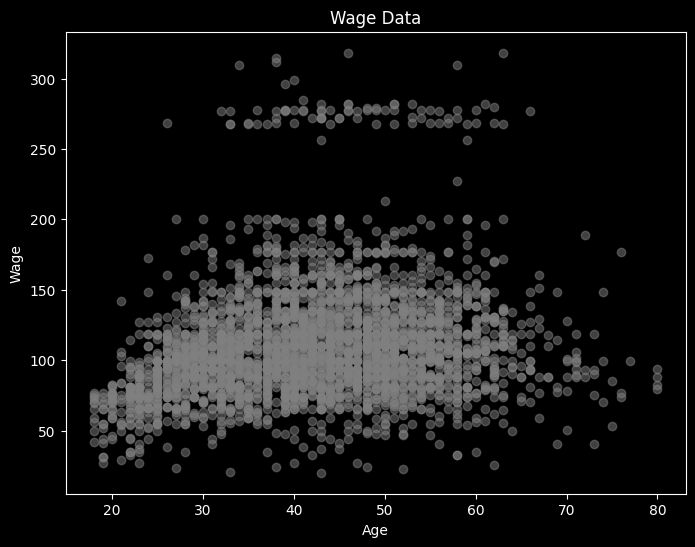

In [2]:
Wage = load_data('Wage')
y = Wage['wage']
age = Wage['age']

# 시각화를 위한 age 값의 그리드 생성
age_grid = np.linspace(age.min(), age.max(), 100)
age_df = pd.DataFrame({'age': age_grid})

fig, ax = subplots(figsize=(8, 6))
ax.scatter(age, y, facecolor='gray', alpha=0.5)
ax.set_xlabel('Age')
ax.set_ylabel('Wage')
ax.set_title('Wage Data')
import matplotlib.pyplot as plt
plt.show()

### 2.1 Step Functions

Step Function은 가장 간단한 기저 함수 중 하나입니다. 전체 구간을 여러 개의 작은 구간(bin)으로 나누고, 각 구간마다 상수 값을 할당하는 방식입니다.

- **Basis**: $\phi_{j}(x)=I_{[c_{j},c_{j+1}]}(x)$
- **고려사항**: 구간의 경계점($c_j$)과 총 구간의 개수($K$)를 어떻게 정할 것인가가 중요합니다.

`pandas`의 `pd.cut` 함수를 사용하여 `age`를 4개의 구간으로 나누고, 각 구간의 평균 `wage`를 계산하여 Step Function을 만들어 보겠습니다.

### 각 구간별 평균 임금 (추정된 계수) ###
                    coef  std err        t  P>|t|
(17.938, 33.5]   94.1584    1.476   63.790    0.0
(33.5, 49.0]    118.2119    1.081  109.379    0.0
(49.0, 64.5]    117.8230    1.448   81.351    0.0
(64.5, 80.0]    101.7990    4.764   21.368    0.0


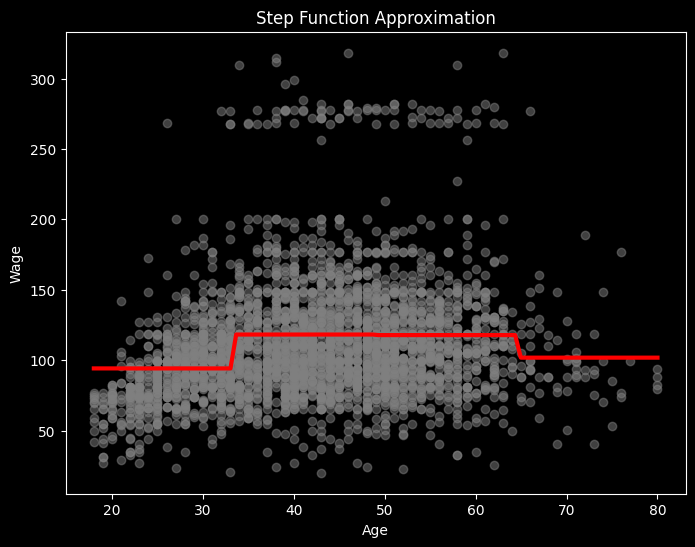

In [3]:
# 1. age를 4개의 구간으로 나눕니다.
age_cut, bins = pd.cut(age, 4, retbins=True, right=True)

# 2. 구간별 더미 변수를 생성하여 선형 모델을 학습합니다.
df_age_cut = pd.get_dummies(age_cut)
M_step = sm.OLS(y, df_age_cut).fit()
print('### 각 구간별 평균 임금 (추정된 계수) ###')
print(summarize(M_step))

# 3. 예측을 위한 그리드 데이터에도 동일한 구간을 적용합니다.
age_grid_cut = pd.get_dummies(pd.cut(age_grid, bins))
preds = M_step.get_prediction(age_grid_cut)

# 4. 시각화
fig, ax = subplots(figsize=(8, 6))
ax.scatter(age, y, facecolor='gray', alpha=0.5)
ax.plot(age_grid, preds.predicted_mean, 'r-', lw=3)
ax.set_xlabel('Age')
ax.set_ylabel('Wage')
ax.set_title('Step Function Approximation')
plt.show()

### 2.2 Piecewise Polynomials & Splines

Step Function보다 더 부드러운 함수를 만들기 위해 구간별로 다항식(polynomial)을 사용합니다. 이때, 각 다항식이 연결되는 지점(**knot**)에서 함수가 부드럽게 이어지도록 제약 조건을 추가한 것을 **Spline**이라고 합니다.

**Cubic Spline**은 3차 다항식을 사용하며, knot에서 연속성, 1차 미분값, 2차 미분값이 같다는 제약 조건을 가집니다. 이로 인해 매우 부드러운 곡선을 얻을 수 있습니다.

`ISLP`의 `bs` (B-spline) 함수를 사용하여 `age`를 3개의 내부 knot (25, 40, 60세)으로 나누는 Cubic Spline 모델을 만들어 보겠습니다.

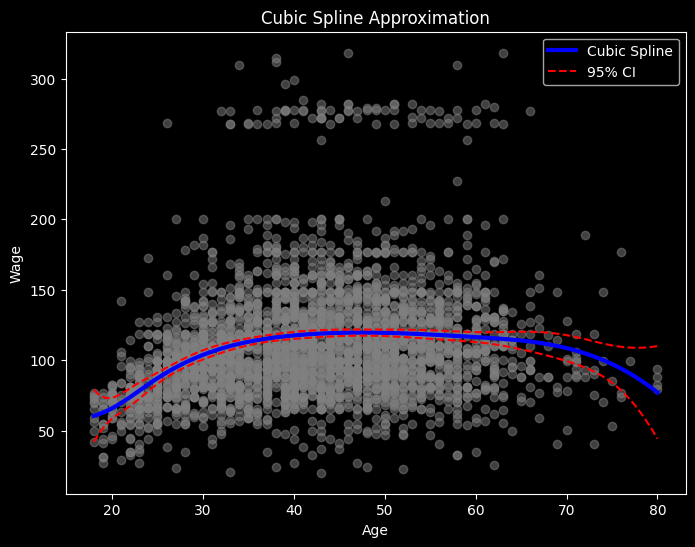

In [4]:
# 1. B-spline basis를 정의합니다. (degree=3이 기본값)
# df(degrees of freedom)는 knot의 개수 + degree + 1 (intercept) 입니다. knot 3개 -> df=3+3+1=7
# ISLP의 bs는 intercept를 제외하므로 df=6이 됩니다.
bs_age_spec = MS([bs('age', internal_knots=[25, 40, 60])])
X_spline = bs_age_spec.fit_transform(Wage)

# 2. 선형 모델을 학습합니다.
M_spline = sm.OLS(y, X_spline).fit()

# 3. 그리드 데이터에 대해 예측합니다.
X_grid_spline = bs_age_spec.transform(age_df)
preds = M_spline.get_prediction(X_grid_spline)
bands = preds.conf_int(alpha=0.05)

# 4. 시각화
fig, ax = subplots(figsize=(8, 6))
ax.scatter(age, y, facecolor='gray', alpha=0.5)
ax.plot(age_grid, preds.predicted_mean, 'b-', lw=3, label='Cubic Spline')
ax.plot(age_grid, bands[:, 0], 'r--', label='95% CI')
ax.plot(age_grid, bands[:, 1], 'r--')
ax.set_xlabel('Age')
ax.set_ylabel('Wage')
ax.set_title('Cubic Spline Approximation')
ax.legend()
plt.show()

### 2.3 Smoothing Splines

Spline에서 knot의 개수와 위치를 정하는 것은 복잡한 문제입니다. **Smoothing Spline**은 이 문제를 해결하는 우아한 접근법을 제시합니다.

모든 데이터 포인트를 knot으로 사용하되, 모델이 과적합되지 않도록 **Roughness Penalty**를 추가한 목적 함수를 최소화합니다.

$$ \text{minimize}_{g \in S} \sum_{i=1}^{n}(y_i - g(x_i))^2 + \lambda \int (g''(t))^2 dt $$

- 첫 번째 항: 데이터에 대한 적합도 (Goodness-of-fit)
- 두 번째 항: 함수의 "거친 정도"(wiggliness)에 대한 페널티
- $\lambda$: 두 항의 균형을 조절하는 튜닝 파라미터. $\lambda$가 크면 함수는 직선에 가까워지고, 작으면 더 구불구불해집니다.

`pygam` 라이브러리를 사용하여 Smoothing Spline을 구현하고, $\lambda$ 값에 따라 곡선이 어떻게 변하는지 확인해 보겠습니다.

In [5]:
from pygam import (s as s_gam,
                   LinearGAM)

X_age = np.asarray(age).reshape((-1,1))
gam = LinearGAM(s_gam(0, lam=0.6))
gam.fit(X_age, y)


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, 
   verbose=False)

`pygam` library는 일반적으로 features matrix를 기대하므로 `age`를 vector(즉, 1차원 배열) 대신 matrix(2차원 배열)로 reshape합니다. `reshape()` 메소드 호출에서 `-1`은 `numpy`에게 shape tuple의 나머지 항목을 기반으로 해당 차원의 크기를 추정하도록 지시합니다.
 
smoothing parameter `lam`에 따라 fit이 어떻게 변하는지 조사해 봅시다. `np.logspace()` 함수는 `np.linspace()`와 유사하지만 log-scale에서 점들을 균일하게 배치합니다. 아래에서는 `lam`을 $10^{-2}$에서 $10^6$까지 변화시킵니다.

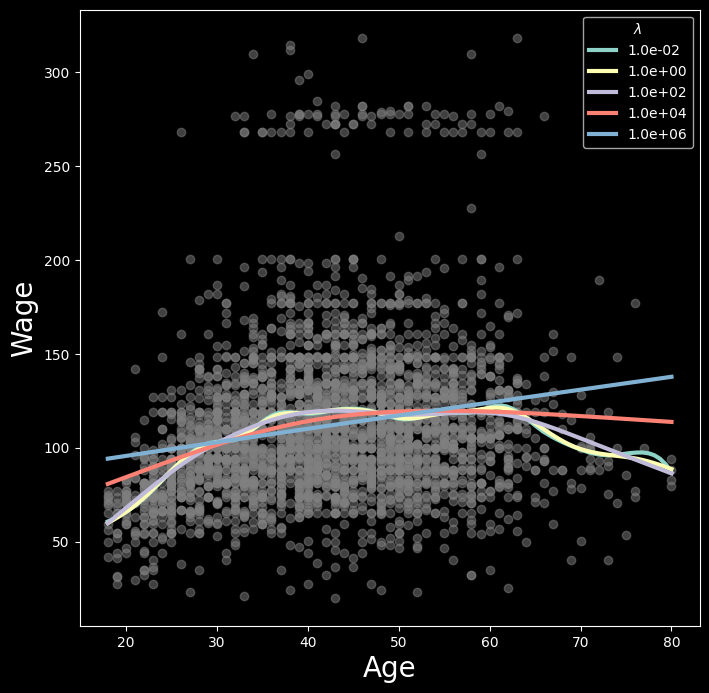

In [6]:
fig, ax = subplots(figsize=(8,8))
ax.scatter(age, y, facecolor='gray', alpha=0.5)

# lambda 값을 변화시키며 모델을 학습하고 시각화합니다.
for lam in np.logspace(-2, 6, 5):
    gam = LinearGAM(s_gam(0, lam=lam)).fit(X_age, y)
    ax.plot(age_grid,
            gam.predict(age_grid),
            label='{:.1e}'.format(lam),
            linewidth=3)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20);
ax.legend(title='$\lambda$');


`pygam` package는 최적의 smoothing parameter를 검색할 수 있습니다.

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


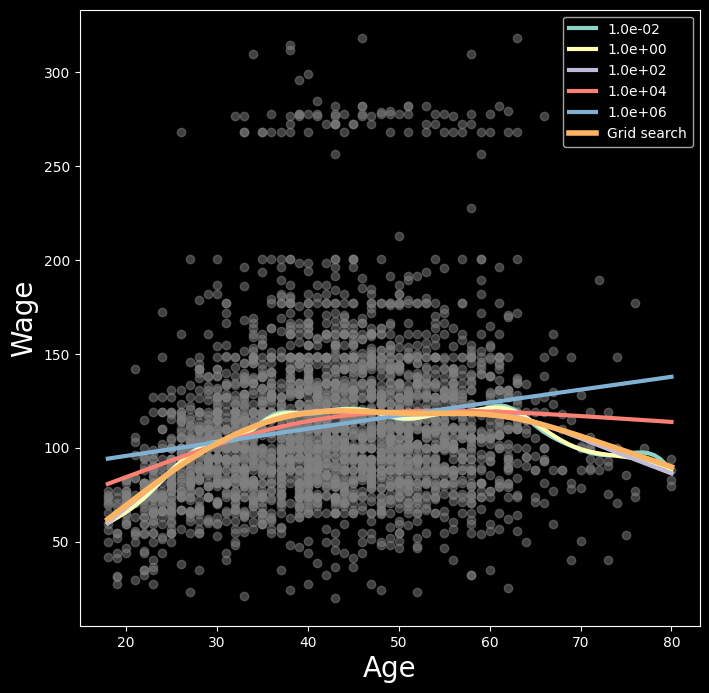

In [7]:
gam_opt = gam.gridsearch(X_age, y)
ax.plot(age_grid,
        gam_opt.predict(age_grid),
        label='Grid search',
        linewidth=4)
ax.legend()
fig


또는, `ISLP.pygam` package에 포함된 함수를 사용하여 smoothing spline의 degrees of freedom을 고정할 수 있습니다. 아래에서는 약 4개의 degrees of freedom을 주는 $\lambda$ 값을 찾습니다. 여기서 이 degrees of freedom은 smoothing spline의 penalty가 없는 intercept와 linear term을 포함하므로, 최소 2개의 degrees of freedom이 있다는 점에 유의해야 합니다.

In [8]:
from ISLP.pygam import (approx_lam,
                        degrees_of_freedom)
age_term = gam.terms[0]
lam_4 = approx_lam(X_age, age_term, 4)
age_term.lam = lam_4
degrees_of_freedom(X_age, age_term)


np.float64(4.00000010000165)

위와 유사한 plot에서 degrees of freedom을 변화시켜 봅시다. 우리는 이 smoothing splines가 항상 intercept term을 갖는다는 사실을 고려하여 원하는 degrees of freedom에 1을 더한 값을 degrees of freedom으로 선택합니다. 따라서 `df`에 대한 값 1은 단지 linear fit입니다.

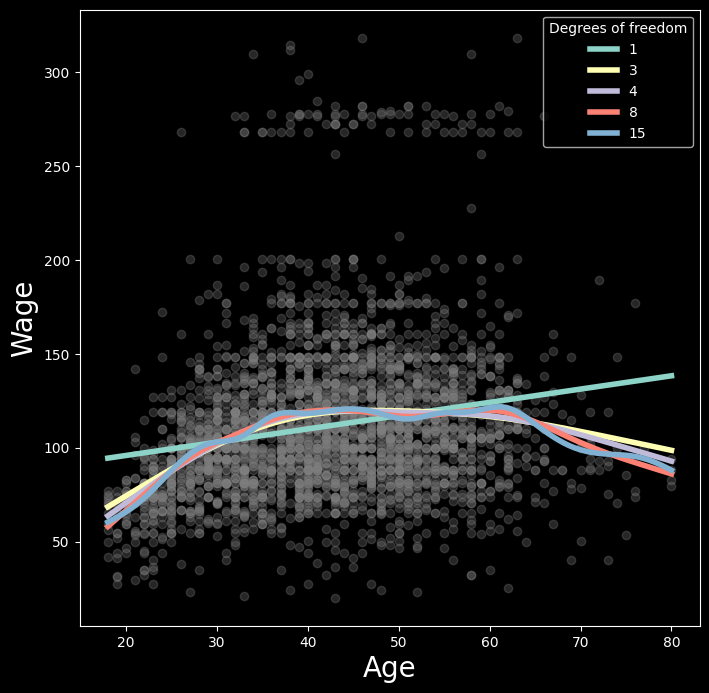

In [9]:
fig, ax = subplots(figsize=(8,8))
ax.scatter(X_age,
           y,
           facecolor='gray',
           alpha=0.3)
for df in [1,3,4,8,15]:
    lam = approx_lam(X_age, age_term, df+1)
    age_term.lam = lam
    gam.fit(X_age, y)
    ax.plot(age_grid,
            gam.predict(age_grid),
            label='{:d}'.format(df),
            linewidth=4)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20);
ax.legend(title='Degrees of freedom');


## 3. Feedforward Neural Network

신경망, 특히 Feedforward Neural Network는 함수 추정을 위한 강력한 도구입니다. Basis Expansion 관점에서 신경망은 **데이터 적응형 기저 함수(Data-adaptive basis)**를 학습하는 모델로 해석할 수 있습니다.

1-hidden-layer 신경망의 수식은 다음과 같습니다:

$$ f(x) = \beta^T g(Wx) = \sum_j \beta_j g(w_j^T x) $$

여기서 $g$는 활성화 함수(activation function)이며, $g(w_j^T x)$가 일종의 기저 함수 역할을 합니다. 기존의 기저 함수들이 미리 정해진 형태를 사용하는 반면, 신경망은 데이터로부터 가중치 $W$를 학습하여 기저 함수의 형태를 스스로 결정합니다.

### Universal Approximation Theorem

충분히 많은 hidden unit이 있다면, 1-hidden-layer 신경망은 어떤 연속 함수든 원하는 정확도로 근사할 수 있습니다. 이는 ReLU와 같은 간단한 활성화 함수들의 합으로 복잡한 함수를 표현할 수 있음을 의미합니다.

`scikit-learn`의 `MLPRegressor`를 사용하여 `Wage` 데이터를 신경망으로 학습시켜 보겠습니다.

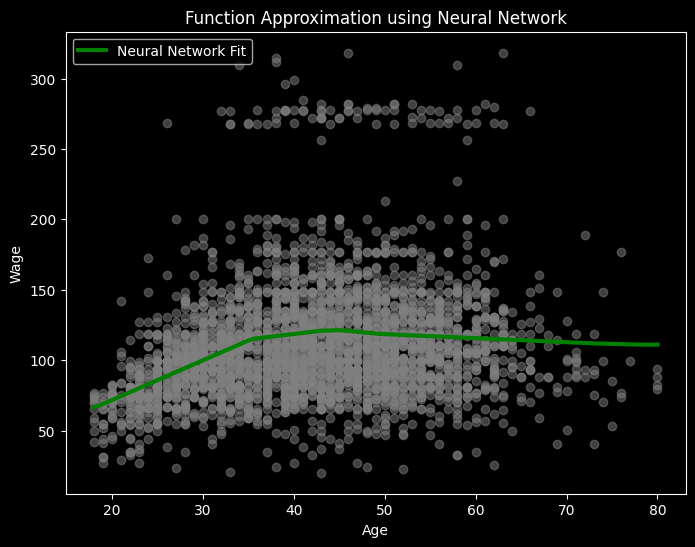

In [10]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

# 1. 데이터 스케일링 (신경망 학습에 중요)
scaler = StandardScaler()
X_age_scaled = scaler.fit_transform(X_age)
age_grid_scaled = scaler.transform(age_grid.reshape(-1, 1))

# 2. 신경망 모델 정의 및 학습
# hidden_layer_sizes=(10, 10): 10개의 유닛을 가진 2개의 은닉층
# activation='relu': ReLU 활성화 함수 사용
mlp = MLPRegressor(hidden_layer_sizes=(50, 25),
                   activation='relu',
                   solver='adam',
                   max_iter=1000,
                   random_state=0)
mlp.fit(X_age_scaled, y)

# 3. 예측
y_pred_mlp = mlp.predict(age_grid_scaled)

# 4. 시각화
fig, ax = subplots(figsize=(8, 6))
ax.scatter(age, y, facecolor='gray', alpha=0.5)
ax.plot(age_grid, y_pred_mlp, 'g-', lw=3, label='Neural Network Fit')
ax.set_xlabel('Age')
ax.set_ylabel('Wage')
ax.set_title('Function Approximation using Neural Network')
ax.legend()
plt.show()

## 4. Feedforward Neural Network (PyTorch 활용)

이번에는 `PyTorch`를 사용하여 Feedforward Neural Network를 직접 구성하고, 시뮬레이션 데이터를 통해 함수 추정 과정을 시각적으로 확인해 보겠습니다. `scikit-learn`이 고수준의 API를 제공한다면, `PyTorch`는 모델의 구조와 학습 과정을 더 세밀하게 제어할 수 있게 해줍니다.

**접근 방식:**
1.  **데이터 생성**: non-linear 형태를 가진 가상의 데이터를 생성합니다. (예: 사인 곡선 + noise)
2.  **모델 정의**: `PyTorch`의 `nn.Module`을 상속받아 간단한 다층 퍼셉트론(MLP) 모델을 직접 설계합니다.
3.  **모델 학습**: 생성한 데이터를 사용하여 정의된 모델을 학습시키고, 손실(loss)이 감소하는 과정을 확인합니다.
4.  **결과 시각화**: 학습된 모델이 원래의 non-linear 함수를 얼마나 잘 근사했는지 시각적으로 비교합니다.

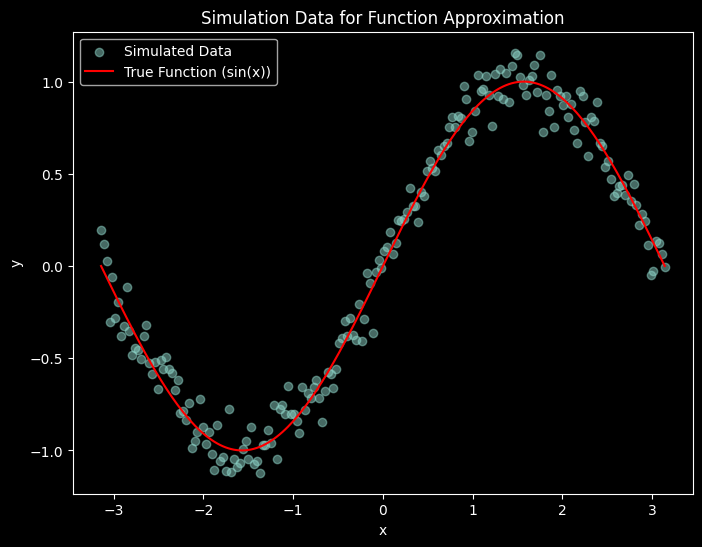

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# 1. 시뮬레이션 데이터 생성
# torch.manual_seed를 통해 재현성을 보장합니다.
torch.manual_seed(42)

# X: -pi부터 pi까지 200개의 점
X = torch.linspace(-np.pi, np.pi, 200).view(-1, 1)

# y: sin(X) 값에 정규분포 노이즈 추가
y = torch.sin(X) + 0.1 * torch.randn(X.size())

# 생성된 데이터 시각화
plt.figure(figsize=(8, 6))
plt.scatter(X.numpy(), y.numpy(), alpha=0.5, label='Simulated Data')
plt.plot(X.numpy(), torch.sin(X).numpy(), 'r-', label='True Function (sin(x))')
plt.title('Simulation Data for Function Approximation')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

### 4.1 PyTorch 모델 정의

입력(1차원)을 받아 출력(1차원)을 내보내는 간단한 신경망을 정의합니다. 2개의 은닉층을 가지며, 활성화 함수로는 **ReLU**를 사용합니다.

In [12]:
class FunctionApproximator(nn.Module):
    def __init__(self):
        super(FunctionApproximator, self).__init__()
        self.hidden1 = nn.Linear(1, 64)  # 입력 차원 1, 은닉층 유닛 64
        self.hidden2 = nn.Linear(64, 64) # 은닉층 유닛 64, 64
        self.output = nn.Linear(64, 1)   # 은닉층 유닛 64, 출력 차원 1
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.output(x)
        return x

# 모델, 손실 함수, 옵티마이저 초기화
model = FunctionApproximator()
criterion = nn.MSELoss()  # 평균 제곱 오차 손실 (회귀 문제)
optimizer = optim.Adam(model.parameters(), lr=0.01) # Adam 옵티마이저

print("PyTorch 모델이 성공적으로 정의되었습니다.")
print(model)

PyTorch 모델이 성공적으로 정의되었습니다.
FunctionApproximator(
  (hidden1): Linear(in_features=1, out_features=64, bias=True)
  (hidden2): Linear(in_features=64, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)


### 4.2 모델 학습 루프

이제 정의된 모델을 사용하여 데이터를 학습시킵니다. 지정된 epoch 수만큼 다음 과정을 반복합니다:
1.  **Forward Pass**: 모델에 입력을 넣어 예측값을 계산합니다.
2.  **Loss Calculation**: 예측값과 실제값의 차이(손실)를 계산합니다.
3.  **Backward Pass**: 손실을 줄이는 방향으로 각 가중치의 그래디언트(기울기)를 계산합니다.
4.  **Weight Update**: 옵티마이저를 사용해 그래디언트를 기반으로 가중치를 업데이트합니다.

In [13]:
epochs = 100

for epoch in range(epochs):
    # 1. Forward pass
    y_pred = model(X)

    # 2. Loss 계산
    loss = criterion(y_pred, y)

    # 3. Backward pass (Gradient 계산)
    optimizer.zero_grad() # 이전 그래디언트 초기화
    loss.backward()

    # 4. 가중치 업데이트
    optimizer.step()

    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [20/100], Loss: 0.0365
Epoch [40/100], Loss: 0.0112
Epoch [60/100], Loss: 0.0094
Epoch [80/100], Loss: 0.0089
Epoch [100/100], Loss: 0.0088


### 4.3 결과 시각화

학습이 완료된 모델이 원래의 `sin(x)` 함수를 얼마나 잘 근사했는지 시각적으로 확인합니다.

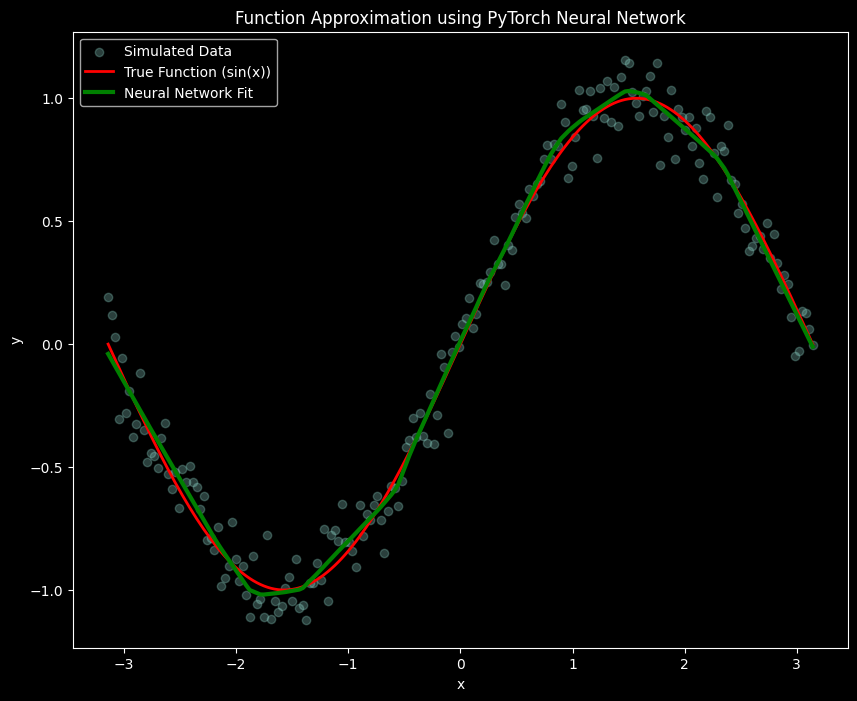

In [14]:
# 모델을 평가 모드로 설정
model.eval()

# torch.no_grad()는 그래디언트 계산을 비활성화하여 예측 시 메모리 사용량을 줄이고 속도를 높입니다.
with torch.no_grad():
    predicted = model(X).detach().numpy()

# 결과 시각화
plt.figure(figsize=(10, 8))
plt.scatter(X.numpy(), y.numpy(), alpha=0.3, label='Simulated Data')
plt.plot(X.numpy(), torch.sin(X).numpy(), 'r-', lw=2, label='True Function (sin(x))')
plt.plot(X.numpy(), predicted, 'g-', lw=3, label='Neural Network Fit')
plt.title('Function Approximation using PyTorch Neural Network')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## 5. 결론 및 요약

이번 실습을 통해 함수를 근사하는 다양한 방법을 알아보았습니다.

- **Basis Expansion**은 미리 정의된 기저 함수들의 선형 결합으로 함수를 표현하는 유연한 접근법입니다. 어떤 기저(Step, Spline 등)를 선택하느냐에 따라 모델의 특성이 달라집니다.

- **Spline**은 구간별 다항식을 부드럽게 연결하여 국소적인 변화를 잘 포착하면서도 안정적인 모델을 만듭니다. 특히 Smoothing Spline은 knot 선택의 어려움을 해결해 줍니다.

- **Neural Network**는 데이터로부터 기저 함수의 형태 자체를 학습하는 강력한 모델입니다. Universal Approximation Theorem에 따라 이론적으로 어떤 함수든 근사할 수 있는 능력을 갖추고 있습니다.